# Data Exploration and Preparation Assignment

### Purpose
The purpose of this assignment is to allow you to implement data exploration and data preparation techniques in Python as covered in previous Modules including:
- Identifying missing data, anomalous data, and outliers.
- Implementing data imputation techniques.
- Justifying the choice of imputation techniques.
- Performing EDA on a chosen dataset.
- Performing cluster analysis using KMeans on a chosen dataset.
- Performing appropriate feature engineering a chosen dataset.
- Performing feature selection on a chosen dataset.

### Instructions
You will be ready to begin this assignment after going through all the required resources posted on Moodle.

You will be performing data exploration and data preparation steps gradually on the dataset you have chosen in Assignment 1:
For each task below, please fill in the code accordingly.

In [1]:
# 1. For each column in the dataset:
# a. Develop the module that identifies
# i. missing data (7 pts)
# ii. outlier data (7 pts)
# iii. anomalous data (7 pts)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install plotly==5.15.0
import plotly.express as px


# Part 1.a.i Identifying Missing Data

data = pd.read_csv('WHO COVID-19 cases.csv')
print(data.head())
print('\nChecking for missing values:')
print(data.isnull().sum())

  Date_reported Country_code      Country Continent WHO_region  New_cases  \
0    2020-01-05           AF  Afghanistan      Asia       EMRO        NaN   
1    2020-01-12           AF  Afghanistan      Asia       EMRO        NaN   
2    2020-01-19           AF  Afghanistan      Asia       EMRO        NaN   
3    2020-01-26           AF  Afghanistan      Asia       EMRO        NaN   
4    2020-02-02           AF  Afghanistan      Asia       EMRO        NaN   

   Cumulative_cases  New_deaths  Cumulative_deaths  
0                 0         NaN                  0  
1                 0         NaN                  0  
2                 0         NaN                  0  
3                 0         NaN                  0  
4                 0         NaN                  0  

Checking for missing values:
Date_reported            0
Country_code           244
Country                  0
Continent                0
WHO_region            4392
New_cases            19300
Cumulative_cases         0


In [3]:
from sklearn.ensemble import HistGradientBoostingClassifier, HistGradientBoostingRegressor
from scipy import stats
from sklearn.ensemble import IsolationForest

# Part 1.a.ii - Identifying Outlier Data

numeric_data = data.select_dtypes(include=np.number)

# 1. Z-score method
outlier_indices_zscore = {}
for column in numeric_data.columns:
    data_without_nan = numeric_data[column].dropna()
    zscores = np.abs(stats.zscore(data_without_nan))
    outlier_indices_zscore[column] = numeric_data[(numeric_data[column].isin(data_without_nan[zscores > 3]))].index.tolist()

# 2. IQR method
outlier_indices_iqr = {}
for column in numeric_data.columns:
    data_without_nan = numeric_data[column].dropna()
    Q1 = data_without_nan.quantile(0.25)
    Q3 = data_without_nan.quantile(0.75)
    IQR = Q3 - Q1
    column_outliers = ((data_without_nan < (Q1 - 1.5 * IQR)) |
                       (data_without_nan > (Q3 + 1.5 * IQR)))
    outlier_indices_iqr[column] = numeric_data[(numeric_data[column].isin(data_without_nan[column_outliers]))].index.tolist()

# 3. Isolation Forest method
isolation_forest_results = {}
for column in numeric_data:
    column_data = data[[column]].dropna()
    iso_forest = IsolationForest(contamination=0.05, random_state=42)
    anomalies = iso_forest.fit_predict(column_data)
    anomaly_count = (anomalies == -1).sum()
    isolation_forest_results[column] = anomaly_count
    data[f'{column}_anomaly'] = 0
    data.loc[column_data.index, f'{column}_anomaly'] = anomalies

# Displaying Results
print("\nOutliers detected using Z-score method:")
for column, indices in outlier_indices_zscore.items():
    print(f"Column '{column}': {len(indices)} outliers")

print("\nOutliers detected using IQR method:")
for column, indices in outlier_indices_iqr.items():
    print(f"Column '{column}': {len(indices)} outliers")

print("\nOutliers detected using Isolation Forest method:")
for column, count in isolation_forest_results.items():
    print(f"Column '{column}': {count} outliers")



Outliers detected using Z-score method:
Column 'New_cases': 118 outliers
Column 'Cumulative_cases': 1106 outliers
Column 'New_deaths': 367 outliers
Column 'Cumulative_deaths': 855 outliers

Outliers detected using IQR method:
Column 'New_cases': 6310 outliers
Column 'Cumulative_cases': 8921 outliers
Column 'New_deaths': 3859 outliers
Column 'Cumulative_deaths': 9216 outliers

Outliers detected using Isolation Forest method:
Column 'New_cases': 1962 outliers
Column 'Cumulative_cases': 2926 outliers
Column 'New_deaths': 1248 outliers
Column 'Cumulative_deaths': 2908 outliers


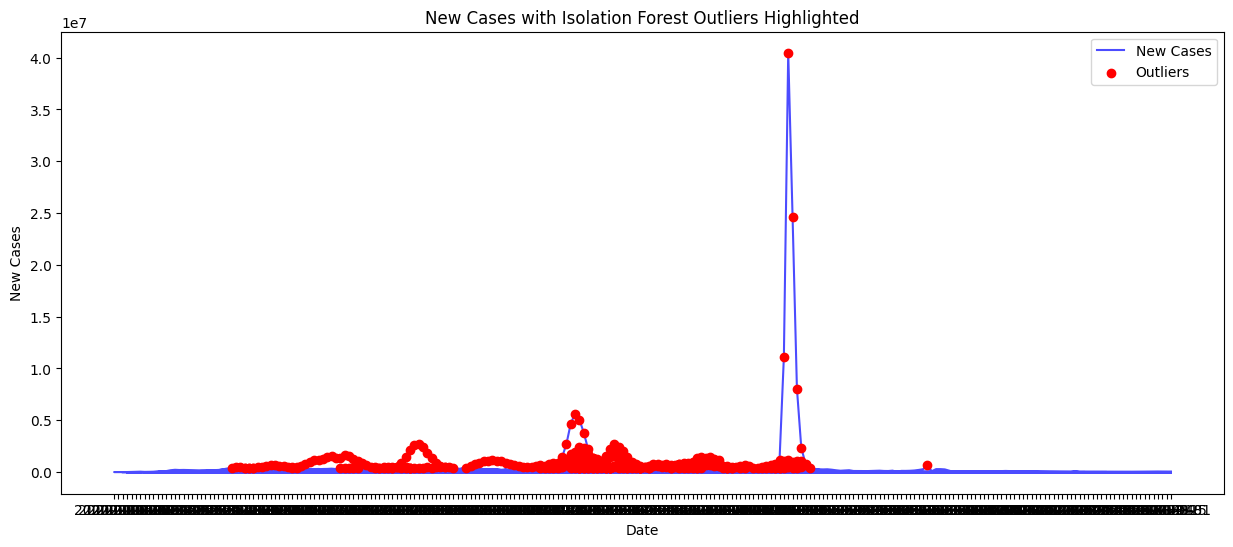

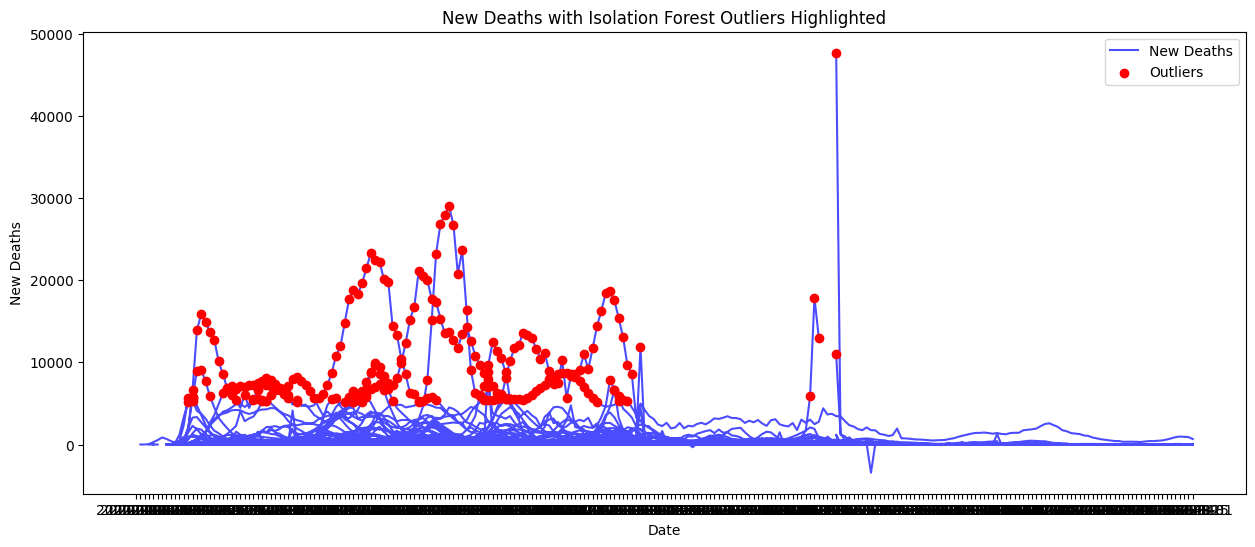

In [4]:
# Visualizing the outliers detected by the Isolation Forest method

iso_forest_cases = IsolationForest(contamination=0.01)
iso_forest_deaths = IsolationForest(contamination=0.01)

data_cases_no_nan = data[['New_cases']].dropna()
data_deaths_no_nan = data[['New_deaths']].dropna()

data['Outlier_cases'] = np.nan
data['Outlier_deaths'] = np.nan

data.loc[data_cases_no_nan.index, 'Outlier_cases'] = iso_forest_cases.fit_predict(data_cases_no_nan)
data.loc[data_deaths_no_nan.index, 'Outlier_deaths'] = iso_forest_deaths.fit_predict(data_deaths_no_nan)

data['Outlier_cases'] = data['Outlier_cases'] == -1
data['Outlier_deaths'] = data['Outlier_deaths'] == -1


plt.figure(figsize=(15, 6))
plt.plot(data['Date_reported'], data['New_cases'], label="New Cases", color='blue', alpha=0.7)
plt.scatter(data['Date_reported'][data['Outlier_cases']], data['New_cases'][data['Outlier_cases']],
            color='red', label="Outliers", zorder=5)
plt.title("New Cases with Isolation Forest Outliers Highlighted")
plt.xlabel("Date")
plt.ylabel("New Cases")
plt.legend()
plt.show()

plt.figure(figsize=(15, 6))
plt.plot(data['Date_reported'], data['New_deaths'], label="New Deaths", color='blue', alpha=0.7)
plt.scatter(data['Date_reported'][data['Outlier_deaths']], data['New_deaths'][data['Outlier_deaths']],
            color='red', label="Outliers", zorder=5)
plt.title("New Deaths with Isolation Forest Outliers Highlighted")
plt.xlabel("Date")
plt.ylabel("New Deaths")
plt.legend()
plt.show()


In [5]:
# Part 1.a.iii - Identifying Anomalous Data

# Time-Series Analysis for Anomalies:

data['Date_reported'] = pd.to_datetime(data['Date_reported'])

def detect_anomalies_for_column(column_name, data):
    column = data[column_name]

    if column.dtype in [np.float64, np.int64]:
        rolling_mean = column.rolling(window=7).mean()
        rolling_std = column.rolling(window=7).std()
        anomaly_threshold = rolling_mean + 2 * rolling_std
        anomalies = data[column_name][data[column_name] > anomaly_threshold]
        return len(anomalies)
    return 0

anomalies_count = {}
for column in numeric_data:
    anomalies_count[column] = detect_anomalies_for_column(column, data)

# Displaying results
print("Anomalies detected using time-series analysis for selected columns:")
for column, count in anomalies_count.items():
    print(f"{column}: {count} anomalies")

# Local Outlier Factor Methods for Anomalies
from sklearn.neighbors import LocalOutlierFactor

def detect_anomalies_with_lof(column_name, data, n_neighbors=20, contamination=0.05):
    column_data = data[column_name].dropna().values.reshape(-1, 1)
    lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination)
    labels = lof.fit_predict(column_data)
    anomalies = (labels == -1).sum()
    return anomalies

lof_anomalies_count = {}
for column in numeric_data:
    lof_anomalies_count[column] = detect_anomalies_with_lof(column, data)

# Displaying results
print("\nAnomalies detected using LOF for selected columns:")
for column, count in lof_anomalies_count.items():
    print(f"{column}: {count} anomalies")



Anomalies detected using time-series analysis for selected columns:
New_cases: 1795 anomalies
Cumulative_cases: 2090 anomalies
New_deaths: 553 anomalies
Cumulative_deaths: 1657 anomalies

Anomalies detected using LOF for selected columns:
New_cases: 1963 anomalies
Cumulative_cases: 2923 anomalies
New_deaths: 1250 anomalies
Cumulative_deaths: 2928 anomalies


In [6]:
# b. Explain the rationale behind the methods used for identifying:
# i. outliers (7 pts)
# ii. anomalous data (7 pts)


b. **Rationale behind the methods used for identifying outliers**

Applied to the data set, these methods resulted in different numbers of outliers:
* The Z-score method found fewer outliers because it uses more stringent criteria and the assumption that the data are normally distributed.
* A much larger number of outliers was pinpointed by the IQR method since it's sensitive to variability and has broader criteria for the detection of outliers.
* The Isolation Forest had detected a moderate number of anomalies, using its prowess in adapting to the structure of the dataset and distinguishing non-linear relationships.

Considering the characteristics of COVID-19 data, which are skew—like sudden spikes in cases or deaths—and hence might potentially show nonlinear relations, Isolation Forest is an appropriate way to find outliers.

The counts of anomalies that Isolation Forest detects are higher than Z-score but more balanced than IQR, which might suggest that it catches a realistic number of anomalies.

b. **Rationale behind the methods used for identifying anomalies**

Applied to the dataset, Time-Series Analysis and Local Outlier Factor (LOF) resulted in different outputs of finding anomalies:

* Time-Series Analysis has caught fewer anomalies because it focuses on contextual anomalies, which is a matter of detecting deviations with respect to transient trends. Although sensitive to sudden rises or falls, it lacks a broader view of patterns across the data set.

* The Local Outlier Factor (LOF) identified more anomalies because it was capable of finding both local and global anomalies, independent of temporal patterns. This method calculates the density of each data point with regard to its neighbors and, therefore, becomes very sensitive to any deviations from the general data distribution.

Given the inherently temporal and short-term fluctuation features of COVID-19 data—like daily surges in cases or deaths—Time-Series Analysis comes up as a suitable method to define trend-based anomalies. The dataset may also reveal, however, non-linear relationships or broad deviations, making LOF a useful complementary technique. The anomalies that Time-Series Analysis catches are more focused on trend-specific outliers, while LOF captures broader patterns. The most complete detection of anomalies in this context might be achieved by a combined approach.


In [7]:
# 2. For each column in the dataset:
# a. Develop the module that imputes missing or anomalous values when needed in two different ways. (7 pts)
# b. Explain the rationale behind the methods used for imputing the data (e.g., based on data types, data distribution, etc.). (7 pts)


In [8]:
# 2.a. Imputing missing values in Country_code column

# Complete list of countries with their respective country code (alphabetical order)
country_code_map = {
    'Afghanistan': 'AF',
    'Albania': 'AL',
    'Algeria': 'DZ',
    'Andorra': 'AD',
    'Angola': 'AO',
    'Antigua and Barbuda': 'AG',
    'Argentina': 'AR',
    'Armenia': 'AM',
    'Australia': 'AU',
    'Austria': 'AT',
    'Azerbaijan': 'AZ',
    'Bahamas': 'BS',
    'Bahrain': 'BH',
    'Bangladesh': 'BD',
    'Barbados': 'BB',
    'Belarus': 'BY',
    'Belgium': 'BE',
    'Belize': 'BZ',
    'Benin': 'BJ',
    'Bhutan': 'BT',
    'Bolivia': 'BO',
    'Bosnia and Herzegovina': 'BA',
    'Botswana': 'BW',
    'Brazil': 'BR',
    'Brunei': 'BN',
    'Bulgaria': 'BG',
    'Burkina Faso': 'BF',
    'Burundi': 'BI',
    'Cabo Verde': 'CV',
    'Cambodia': 'KH',
    'Cameroon': 'CM',
    'Canada': 'CA',
    'Central African Republic': 'CF',
    'Chad': 'TD',
    'Chile': 'CL',
    'China': 'CN',
    'Colombia': 'CO',
    'Comoros': 'KM',
    'Congo (Congo-Brazzaville)': 'CG',
    'Congo (Democratic Republic of the Congo)': 'CD',
    'Costa Rica': 'CR',
    'Croatia': 'HR',
    'Cuba': 'CU',
    'Cyprus': 'CY',
    'Czech Republic': 'CZ',
    'Denmark': 'DK',
    'Djibouti': 'DJ',
    'Dominica': 'DM',
    'Dominican Republic': 'DO',
    'Ecuador': 'EC',
    'Egypt': 'EG',
    'El Salvador': 'SV',
    'Equatorial Guinea': 'GQ',
    'Eritrea': 'ER',
    'Estonia': 'EE',
    'Eswatini (fmr. "Swaziland")': 'SZ',
    'Ethiopia': 'ET',
    'Fiji': 'FJ',
    'Finland': 'FI',
    'France': 'FR',
    'Gabon': 'GA',
    'Gambia': 'GM',
    'Georgia': 'GE',
    'Germany': 'DE',
    'Ghana': 'GH',
    'Greece': 'GR',
    'Grenada': 'GD',
    'Guatemala': 'GT',
    'Guinea': 'GN',
    'Guinea-Bissau': 'GW',
    'Guyana': 'GY',
    'Haiti': 'HT',
    'Honduras': 'HN',
    'Hungary': 'HU',
    'Iceland': 'IS',
    'India': 'IN',
    'Indonesia': 'ID',
    'Iran': 'IR',
    'Iraq': 'IQ',
    'Ireland': 'IE',
    'Israel': 'IL',
    'Italy': 'IT',
    'Jamaica': 'JM',
    'Japan': 'JP',
    'Jordan': 'JO',
    'Kazakhstan': 'KZ',
    'Kenya': 'KE',
    'Kiribati': 'KI',
    'Korea (North)': 'KP',
    'Korea (South)': 'KR',
    'Kuwait': 'KW',
    'Kyrgyzstan': 'KG',
    'Laos': 'LA',
    'Latvia': 'LV',
    'Lebanon': 'LB',
    'Lesotho': 'LS',
    'Liberia': 'LR',
    'Libya': 'LY',
    'Liechtenstein': 'LI',
    'Lithuania': 'LT',
    'Luxembourg': 'LU',
    'Madagascar': 'MG',
    'Malawi': 'MW',
    'Malaysia': 'MY',
    'Maldives': 'MV',
    'Mali': 'ML',
    'Malta': 'MT',
    'Marshall Islands': 'MH',
    'Mauritania': 'MR',
    'Mauritius': 'MU',
    'Mexico': 'MX',
    'Micronesia': 'FM',
    'Moldova': 'MD',
    'Monaco': 'MC',
    'Mongolia': 'MN',
    'Montenegro': 'ME',
    'Morocco': 'MA',
    'Mozambique': 'MZ',
    'Myanmar (formerly Burma)': 'MM',
    'Namibia': 'NA',
    'Nauru': 'NR',
    'Nepal': 'NP',
    'Netherlands': 'NL',
    'New Zealand': 'NZ',
    'Nicaragua': 'NI',
    'Niger': 'NE',
    'Nigeria': 'NG',
    'North Macedonia': 'MK',
    'Norway': 'NO',
    'Oman': 'OM',
    'Pakistan': 'PK',
    'Palau': 'PW',
    'Panama': 'PA',
    'Papua New Guinea': 'PG',
    'Paraguay': 'PY',
    'Peru': 'PE',
    'Philippines': 'PH',
    'Poland': 'PL',
    'Portugal': 'PT',
    'Qatar': 'QA',
    'Romania': 'RO',
    'Russia': 'RU',
    'Rwanda': 'RW',
    'Saint Kitts and Nevis': 'KN',
    'Saint Lucia': 'LC',
    'Saint Vincent and the Grenadines': 'VC',
    'Samoa': 'WS',
    'San Marino': 'SM',
    'Sao Tome and Principe': 'ST',
    'Saudi Arabia': 'SA',
    'Senegal': 'SN',
    'Serbia': 'RS',
    'Seychelles': 'SC',
    'Sierra Leone': 'SL',
    'Singapore': 'SG',
    'Slovakia': 'SK',
    'Slovenia': 'SI',
    'Solomon Islands': 'SB',
    'Somalia': 'SO',
    'South Africa': 'ZA',
    'South Sudan': 'SS',
    'Spain': 'ES',
    'Sri Lanka': 'LK',
    'Sudan': 'SD',
    'Suriname': 'SR',
    'Sweden': 'SE',
    'Switzerland': 'CH',
    'Syria': 'SY',
    'Taiwan': 'TW',
    'Tajikistan': 'TJ',
    'Tanzania': 'TZ',
    'Thailand': 'TH',
    'Timor-Leste': 'TL',
    'Togo': 'TG',
    'Tonga': 'TO',
    'Trinidad and Tobago': 'TT',
    'Tunisia': 'TN',
    'Turkey': 'TR',
    'Turkmenistan': 'TM',
    'Tuvalu': 'TV',
    'Uganda': 'UG',
    'Ukraine': 'UA',
    'United Arab Emirates': 'AE',
    'United Kingdom': 'GB',
    'United States of America': 'US',
    'Uruguay': 'UY',
    'Uzbekistan': 'UZ',
    'Vanuatu': 'VU',
    'Vatican City': 'VA',
    'Venezuela': 'VE',
    'Vietnam': 'VN',
    'Yemen': 'YE',
    'Zambia': 'ZM',
    'Zimbabwe': 'ZW',
}

# Filling missing country codes using the country names
data['Country_code'] = data.apply(
    lambda row: country_code_map.get(row['Country'], row['Country_code']),
    axis=1
)

# Verifying missing values after filling
missing_country_codes_after = data['Country_code'].isnull().sum()
print(f"Missing Country Codes After Imputation: {missing_country_codes_after}")

# Displaying the updated dataset
print(data[['Country', 'Country_code']].head())


Missing Country Codes After Imputation: 0
       Country Country_code
0  Afghanistan           AF
1  Afghanistan           AF
2  Afghanistan           AF
3  Afghanistan           AF
4  Afghanistan           AF


In [9]:
# Imputing missing values in WHO_region column

# Complete list of countries with their respective WHO regions (alphabetical order)
country_to_who_region = {
    "Afghanistan": "EMRO", "Albania": "EURO", "Algeria": "AFRO", "Andorra": "EURO", "Angola": "AFRO",
    "Antigua and Barbuda": "AMRO", "Argentina": "AMRO", "Armenia": "EURO", "Australia": "WPRO",
    "Austria": "EURO", "Azerbaijan": "EURO", "Bahamas": "AMRO", "Bahrain": "EMRO", "Bangladesh": "SEARO",
    "Barbados": "AMRO", "Belarus": "EURO", "Belgium": "EURO", "Belize": "AMRO", "Benin": "AFRO", "Bhutan": "SEARO",
    "Bolivia": "AMRO", "Bosnia and Herzegovina": "EURO", "Botswana": "AFRO", "Brazil": "AMRO", "Brunei Darussalam": "WPRO",
    "Bulgaria": "EURO", "Burkina Faso": "AFRO", "Burundi": "AFRO", "Cabo Verde": "AFRO", "Cambodia": "WPRO",
    "Cameroon": "AFRO", "Canada": "AMRO", "Central African Republic": "AFRO", "Chad": "AFRO", "Chile": "AMRO",
    "China": "WPRO", "Colombia": "AMRO", "Comoros": "AFRO", "Congo (Congo-Brazzaville)": "AFRO", "Congo (Congo-Kinshasa)": "AFRO",
    "Costa Rica": "AMRO", "Croatia": "EURO", "Cuba": "AMRO", "Cyprus": "EURO", "Czech Republic": "EURO",
    "Denmark": "EURO", "Djibouti": "AFRO", "Dominica": "AMRO", "Dominican Republic": "AMRO", "Ecuador": "AMRO",
    "Egypt": "AFRO", "El Salvador": "AMRO", "Equatorial Guinea": "AFRO", "Eritrea": "AFRO", "Estonia": "EURO",
    "Eswatini": "AFRO", "Ethiopia": "AFRO", "Fiji": "WPRO", "Finland": "EURO", "Faroe Islands" : "EURO", "France": "EURO",
    "French Guiana" : "AMRO" ,"Falkland Islands (Malvinas)": "WPRO", "Saint Helena" : "AFRO", "Gibraltar" : "EURO", "Saint Barthélemy" : "EURO",
    "Saint Martin" : "EURO", "Saint Pierre and Miquelon" : "AMRO", "Saint Pierre and Miquelon" : "AMRO",
    "Gabon": "AFRO", "Gambia": "AFRO", "Georgia": "EURO", "Germany": "EURO", "Ghana": "AFRO", "Greece": "EURO",
    "Grenada": "AMRO", "Guatemala": "AMRO", "Guinea": "AFRO", "Guinea-Bissau": "AFRO", "Guyana": "AMRO",
    "Haiti": "AMRO", "Honduras": "AMRO", "Hungary": "EURO", "Iceland": "EURO", "India": "SEARO", "Indonesia": "SEARO",
    "Iran": "EMRO", "Iraq": "EMRO", "Ireland": "EURO", "Israel": "EMRO", "Italy": "EURO", "Jamaica": "AMRO",
    "Japan": "WPRO", "Jordan": "EMRO", "Kazakhstan": "EURO", "Kenya": "AFRO", "Kiribati": "WPRO", "Korea (North)": "WPRO",
    "Korea (South)": "WPRO", "Kuwait": "EMRO", "Kyrgyzstan": "EURO", "Laos": "WPRO", "Latvia": "EURO", "Lebanon": "EMRO",
    "Lesotho": "AFRO", "Liberia": "AFRO", "Libya": "EMRO", "Liechtenstein": "EURO", "Lithuania": "EURO", "Luxembourg": "EURO",
    "Madagascar": "AFRO", "Malawi": "AFRO", "Malaysia": "WPRO", "Maldives": "SEARO", "Mali": "AFRO", "Malta": "EURO",
    "Marshall Islands": "WPRO", "Mauritania": "AFRO", "Mauritius": "AFRO", "Mexico": "AMRO", "Micronesia (Federated States of)": "WPRO",
    "Moldova": "EURO", "Monaco": "EURO", "Mongolia": "WPRO", "Montenegro": "EURO", "Morocco": "AFRO", "Mozambique": "AFRO",
    "Myanmar (formerly Burma)": "SEARO", "Namibia": "AFRO", "Nauru": "WPRO", "Nepal": "SEARO", "Netherlands": "EURO",
    "New Zealand": "WPRO", "Nicaragua": "AMRO", "Niger": "AFRO", "Nigeria": "AFRO", "North Macedonia": "EURO", "Norway": "EURO",
    "Oman": "EMRO", "Pakistan": "SEARO", "Palau": "WPRO", "Panama": "AMRO", "Papua New Guinea": "WPRO", "Paraguay": "AMRO",
    "Peru": "AMRO", "Philippines": "WPRO", "Poland": "EURO", "Portugal": "EURO", "Qatar": "EMRO", "Romania": "EURO",
    "Russia": "EURO", "Rwanda": "AFRO", "Saint Kitts and Nevis": "AMRO", "Saint Lucia": "AMRO", "Saint Martin (French Part)" : "EURO", "Saint Pierre And Miquelon" : "AMRO", "Saint Vincent and the Grenadines": "AMRO",
    "Samoa": "WPRO", "San Marino": "EURO", "Sao Tome and Principe": "AFRO", "Saudi Arabia": "EMRO", "Senegal": "AFRO",
    "Serbia": "EURO", "Seychelles": "AFRO", "Sierra Leone": "AFRO", "Singapore": "WPRO", "Slovakia": "EURO", "Slovenia": "EURO",
    "Solomon Islands": "WPRO", "Somalia": "AFRO", "South Africa": "AFRO", "South Sudan": "AFRO", "Spain": "EURO", "Sri Lanka": "SEARO",
    "Sudan": "AFRO", "Suriname": "AMRO", "Sweden": "EURO", "Switzerland": "EURO", "Syria": "EMRO", "Taiwan": "WPRO",
    "Tajikistan": "EURO", "Tanzania": "AFRO", "Thailand": "WPRO", "Timor-Leste": "SEARO", "Togo": "AFRO", "Tonga": "WPRO",
    "Trinidad and Tobago": "AMRO", "Tunisia": "EMRO", "Turkey": "EURO", "Turkmenistan": "EMRO", "Tuvalu": "WPRO",
    "Uganda": "AFRO", "Ukraine": "EURO", "United Arab Emirates": "EMRO", "United Kingdom": "EURO", "United States": "AMRO",
    "Uruguay": "AMRO", "Uzbekistan": "EMRO", "Vanuatu": "WPRO", "Venezuela": "AMRO", "Vietnam": "WPRO", "Yemen": "EMRO",
    "Zambia": "AFRO", "Zimbabwe": "AFRO", "Guadeloupe" : "AMRO", "Réunion" : "AFRO", "Guernsey" : "EURO", "Pitcairn" : "WPRO", "Holy See" : "EURO",
    "Mayotte" : "AFRO", "Isle Of Man" : "EURO", "Martinique" : "AMRO", "Jersey" : "EURO", "Saint Barthelemy" : "EURO", "Isle of Man" : "EURO", "Saint Martin (French part)" : "EURO",
}
# Filling missing WHO regions using the country names

data['WHO_region'] = data.apply(
    lambda row: country_to_who_region.get(row['Country'], row['WHO_region']),
    axis=1
)

# Verifying missing values after filling
missing_who_regions_after = data['WHO_region'].isnull().sum()
print(f"Missing WHO Region After Imputation: {missing_who_regions_after}")

# Displaying the updated dataset
print(data[['Country', 'WHO_region']].head())



Missing WHO Region After Imputation: 0
       Country WHO_region
0  Afghanistan       EMRO
1  Afghanistan       EMRO
2  Afghanistan       EMRO
3  Afghanistan       EMRO
4  Afghanistan       EMRO


In [10]:
# Imputating missing values in New_cases and New_deaths columns

# Fill missing values in 'New_cases' and 'New_deaths' with zeros
data['New_cases'] = data['New_cases'].fillna(0)
data['New_deaths'] = data['New_deaths'].fillna(0)

# Displaying the updated dataset
print(data[['Date_reported', 'New_cases','New_deaths']].head())


  Date_reported  New_cases  New_deaths
0    2020-01-05        0.0         0.0
1    2020-01-12        0.0         0.0
2    2020-01-19        0.0         0.0
3    2020-01-26        0.0         0.0
4    2020-02-02        0.0         0.0


In [11]:
# Fixing negative values
columns_to_check = ['New_cases', 'New_deaths']
for column in columns_to_check:
    data[column] = data[column].apply(lambda x: 0 if x < 0 else x)
print(data[['New_cases', 'New_deaths']].head(20))

    New_cases  New_deaths
0         0.0         0.0
1         0.0         0.0
2         0.0         0.0
3         0.0         0.0
4         0.0         0.0
5         0.0         0.0
6         0.0         0.0
7         0.0         0.0
8         1.0         0.0
9         0.0         0.0
10        6.0         0.0
11       17.0         0.0
12       67.0         2.0
13      183.0         3.0
14      247.0        10.0
15      387.0        15.0
16      422.0        13.0
17      841.0        21.0
18     1392.0        41.0
19     2490.0        48.0


In [12]:
# Imputing the outliers in New_cases and New deaths columns
data['Date_reported'] = pd.to_datetime(data['Date_reported'])

start_date = '2023-01-01'
end_date = '2024-09-01'
data_filtered = data[(data['Date_reported'] >= start_date) & (data['Date_reported'] <= end_date)]

def cap_outliers(series, lower_percentile=5, upper_percentile=95):
    lower_limit = np.percentile(series, lower_percentile)
    upper_limit = np.percentile(series, upper_percentile)
    return np.clip(series, lower_limit, upper_limit)

data_filtered['New_cases'] = cap_outliers(data_filtered['New_cases'])
data_filtered['New_deaths'] = cap_outliers(data_filtered['New_deaths'])

data_filtered['Cumulative_cases'] = data_filtered['New_cases'].cumsum()
data_filtered['Cumulative_deaths'] = data_filtered['New_deaths'].cumsum()

# Displaying the updated dataset
print(data_filtered[['Date_reported', 'New_cases', 'New_deaths', 'Cumulative_cases', 'Cumulative_deaths']].head(20))



    Date_reported  New_cases  New_deaths  Cumulative_cases  Cumulative_deaths
156    2023-01-01      257.0         4.0             257.0                4.0
157    2023-01-08      201.0         2.0             458.0                6.0
158    2023-01-15      173.0         4.0             631.0               10.0
159    2023-01-22      144.0         5.0             775.0               15.0
160    2023-01-29      323.0         6.0            1098.0               21.0
161    2023-02-05      272.0         8.0            1370.0               29.0
162    2023-02-12      164.0         3.0            1534.0               32.0
163    2023-02-19      230.0         0.0            1764.0               32.0
164    2023-02-26      165.0         1.0            1929.0               33.0
165    2023-03-05      118.0         1.0            2047.0               34.0
166    2023-03-12      141.0         1.0            2188.0               35.0
167    2023-03-19      239.0         1.0            2427.0      

<ipython-input-12-25bc86bcd059>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['New_cases'] = cap_outliers(data_filtered['New_cases'])
<ipython-input-12-25bc86bcd059>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['New_deaths'] = cap_outliers(data_filtered['New_deaths'])
<ipython-input-12-25bc86bcd059>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [13]:
# Save the DataFrame to a new CSV file

data.to_csv('updated_covid_data.csv', index=False)


2.b.

**Imputing missing values in Country_code column:**

The imputation method that has been used to replace missing values in the `Country_code` column is a mapping approach that assigns a unique and pre-determined code to each specific country. This method takes advantage of the categorical nature of the data where every country is mapped to some standardized and invariant country code. A mapping dictionary called `country_code_map` was created such that missing values are filled based directly on a mapping of `Country` column to its appropriate code. This is extremely effective because it provides contextual accuracy, avoids statistical inference, and keeps the integrity of data intact. It is deterministic and efficient since it is not a statistical imputation method like mean or mode, which is not applicable to categorical data and does not have the use of randomness in the mapping approach. Further verification of the methodology includes checking for remaining missing values to provide guarantees on completeness and consistency in the imputation. This approach is aligned with the dataset structure because it preserves the logical relationship between countries and their codes, ensuring the accuracy of the representation.

**Imputing missing values in WHO_region column:**

As shown above, imputation for missing values in the `WHO_region` column also follows the mapping approach—as was done for the `Country_code` column. In this case, each country is mapped to its World Health Organization (WHO) region using a predefined dictionary (`country_to_who_region`). This will take advantage of the categorical nature of the data, where each country has a constant and standardized relation to a WHO region, which will ensure consistency as well as accuracy. As explained above, it will avoid inappropriate statistical imputation techniques, like using the mode or randomly assigning, which would not produce appropriate regional groupings. By explicitly aligning country names with their respective regions, this deterministic approach guarantees that the imputation will not only be precise but also contextually appropriate. The process further includes a verification step to ensure that all missing values have been filled, thus preserving the integrity and reliability of the data.

**Imputing missing values in New_cases and New_deaths columns:**

The imputation method used is in line with the intrinsic features and context of the dataset. In this case, zeros were substituted for missing values in both `New_cases` and `New_deaths`. This was selected because, logically, the absence of values in these columns indicates that there were no new cases or deaths registered on those days. It imputes missing values by filling them with zero; thus, it maintains consistency, ensuring that the dataset integrity is not compromised by adding inaccuracies. Zero imputation, unlike the use of statistical or interpolation methods, does not misrepresent the absence of cases or deaths; it reflects what the missing values mean in the real world. In simple terms, this will retain the usability of the dataset while sustaining its reliability for further analysis.

**Imputing the negative numbers in New_cases and New_deaths columns:**

The method used in replacing any occurrence of negative values with zero is in columns like `New_cases` and `New_deaths`. It, in essence, presumes that negative values in these columns, when dealing with COVID-19 data, are in effect invalid or nonsense for these fields, as values of new cases or deaths logically cannot be negative. Moreover, Cumulative_cases and Cumulative_deaths were not affected by those negative values for both cases and deaths, which indicates that those negative values most probably were the result of an error or anomaly in the reporting process, not valid entries. Accuracy in cumulative counts—which correspond to expected results—gives credence to the proposition that negative values in the `New_cases` and `New_deaths` columns should be replaced by zero. In doing so, this ensures that a dataset retains the logical consistency of the premise that new cases and death cannot be negative, hence facilitating data integrity for further analyses and modeling.

**Imputing outliers in New_cases and New_deaths columns:**

The rationale for using capping (Winsorization) to treat outliers in the "New_cases" and "New_deaths" columns, mainly for the year 2023, is to avoid having extreme values bias the analysis while still keeping the general integrity of the data. Because it is expected that there will be spikes in new cases and deaths during a pandemic, most particularly in the earlier years, we do not want to remove these fluctuations entirely because they may represent legitimate events and not just errors. However, capping extreme values at some reasonable threshold prevents any outlier from disproportionately affecting the results, such as the mean or variance. This approach also ensures that cumulative measures, defined as the sum of newly reported cases and fatalities, retain their consistency and accuracy. Capping extreme values rather than excluding them preserves a realistic distribution of data, especially for large numbers that may be the result of temporary peaks that do not mirror a wider trend. This approach will retain the overall structure of the data and reduce the effect of truly extreme values that may skew further analyses, thereby making the dataset more robust and representative of the real situation.

In [14]:
# 3. Describe ways that your dataset can be aggregated across multiple features in meaningful and interesting ways (7 pts),
# and explain how that may be helpful for future (causal or predictive) analysis on the dataset. (7 pts)


The Kaggle WHO COVID-19 cases dataset can be aggregated across multiple features in a way
that supports casual or predictive analyses. For example, this can be done at a geographical
level whether regional or by country, then we can compute cumulative cases, deaths and
recovery rates for each level. This identifies hotspots and underreported regions and helps in
predicting the efforts of regional policies on case trajectories. Another approach is applying
temporal aggregation by summarizing data by day, month or year, which detects trends like
spikes or lulls over time. This mainly facilitates the early detection of outbreaks in the future.
Moreover, calculating rates like case growth rates or recovery rates and aggregating them by
geographical or temporal features enhances the understanding of how fast the pandemic
spreads or subsides, as it helps parametrize predictive models for outbreak spread. All these
different aggregations and more have a great impact on forecasting case numbers, healthcare
demands, or economic impacts, and also on policy designs which provides frameworks for rapid
decision-making in future pandemics.

In [15]:
# 4. Develop a module that aggregates the data as you described in (3) above. (7 pts)

# Function to aggregate data by geographical level (e.g., country)
def aggregate_by_geography(data, level='Country'):
#Returns a DataFrame with aggregated cases and deaths at the specified geographic level.
    return data.groupby(level)[['Cumulative_cases', 'Cumulative_deaths']].sum().reset_index()

# Function to aggregate data by time period (e.g., daily, weekly, monthly)
def aggregate_by_time(data, period='D'):
#Returns a DataFrame with aggregated data by the given time period.
    data['Date_reported'] = pd.to_datetime(data['Date_reported'])
    data_resampled = data.resample(period, on='Date_reported')[['Cumulative_cases', 'Cumulative_deaths']].sum()
    return data_resampled

# Function to compute rates (e.g., case fatality rate)
def compute_rates(data):
    data['Case Fatality Rate'] = (data['Cumulative_deaths'] / data['Cumulative_cases']) * 100
    return data

# Function to aggregate by policy-related information (e.g., lockdowns, travel restrictions)
def aggregate_by_policy(data, policy_column='Lockdown Status'):
    return data.groupby(policy_column)[['Cumulative_cases', 'Cumulative_deaths']].sum().reset_index()

# Function to calculate rates based on aggregation results
def calculate_aggregation_rates(data):
    data['Case Fatality Rate'] = (data['Cumulative_deaths'] / data['Cumulative_cases']) * 100
    return data

if __name__ == '__main__':

    # Example of aggregation by geographical level (country)
    aggregated_by_country = aggregate_by_geography(data, level='Country')
    print(aggregated_by_country.head())

    # Example of temporal aggregation by time (month)
    aggregated_by_month = aggregate_by_time(data, period='ME')
    print(aggregated_by_month.head())


          Country  Cumulative_cases  Cumulative_deaths
0     Afghanistan          36283751            1393497
1         Albania          52432380             634679
2         Algeria          47240434            1234746
3  American Samoa           1025469               4195
4         Andorra           7238493              30462
               Cumulative_cases  Cumulative_deaths
Date_reported                                     
2020-01-31                 2218                 75
2020-02-29               200503               5543
2020-03-31              1392350              67204
2020-04-30              7755061             587857
2020-05-31             22651322            1658546


In [16]:
# 5. Develop the module that visualizes those aggregations in all interesting ways possible.
# Use stacking to a large extent possible to allow for overlaid, multidimensional analyses. (7 pts)


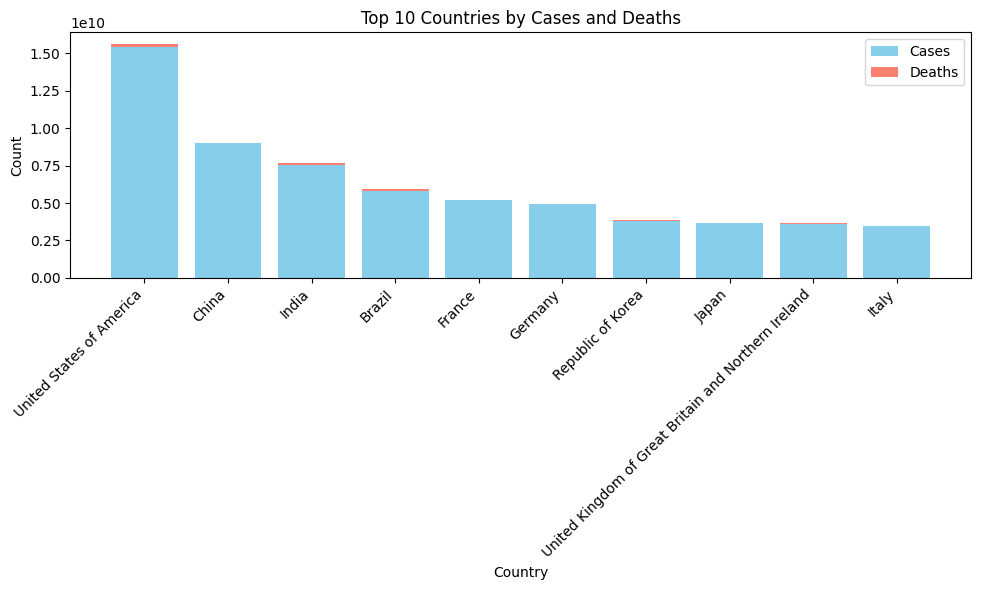

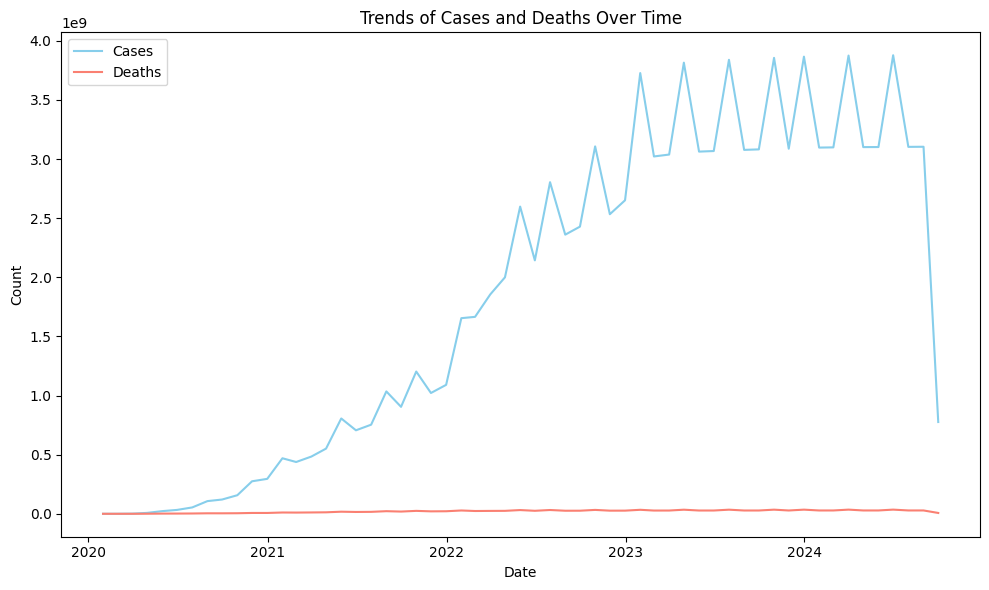

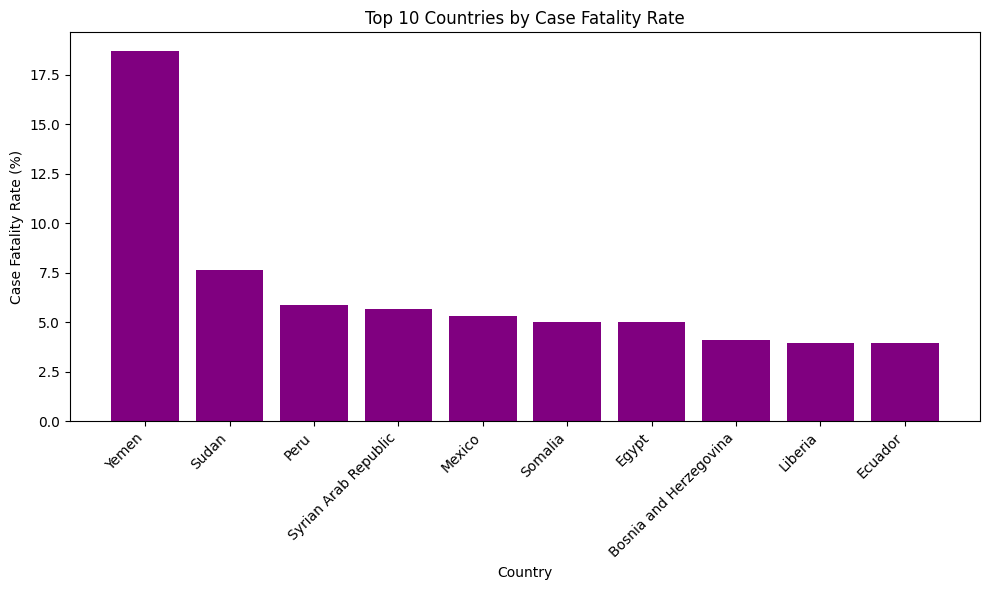

In [17]:
# Function to visualize geographic aggregation

def visualize_geographic_aggregation(data, level='Country'):
    """
    Visualizes geographic aggregation using a bar chart.
    """

    data_sorted = data.sort_values('Cumulative_cases', ascending=False).head(10)  # Top 10 regions
    plt.figure(figsize=(10, 6))
    plt.bar(data_sorted[level], data_sorted['Cumulative_cases'], color='skyblue', label='Cases')
    plt.bar(data_sorted[level], data_sorted['Cumulative_deaths'], color='salmon', label='Deaths', bottom=data_sorted['Cumulative_cases'] - data_sorted['Cumulative_deaths'])
    plt.title(f"Top 10 Countries by Cases and Deaths")
    plt.ylabel("Count")
    plt.xlabel(level)
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Function to visualize temporal aggregation
def visualize_temporal_aggregation(data):
    """
    Visualizes temporal aggregation using a line plot.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(data.index, data['Cumulative_cases'], label='Cases', color='skyblue')
    plt.plot(data.index, data['Cumulative_deaths'], label='Deaths', color='salmon')
    plt.title("Trends of Cases and Deaths Over Time")
    plt.ylabel("Count")
    plt.xlabel("Date")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Function to visualize rates (e.g., case fatality rate)
def visualize_rates(data, level='Country'):
    """
    Visualizes rates using a bar chart.
    """
    data_sorted = data.sort_values('Case Fatality Rate', ascending=False).head(10)  # Top 10 regions
    plt.figure(figsize=(10, 6))
    plt.bar(data_sorted[level], data_sorted['Case Fatality Rate'], color='purple')
    plt.title(f"Top 10 Countries by Case Fatality Rate")
    plt.ylabel("Case Fatality Rate (%)")
    plt.xlabel(level)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Example usage
if __name__ == '__main__':
    # Aggregations
    aggregated_by_country = aggregate_by_geography(data, level='Country')
    aggregated_by_month = aggregate_by_time(data, period='ME')
    data_with_rates = compute_rates(aggregated_by_country)

    # Visualizations
    visualize_geographic_aggregation(aggregated_by_country, level='Country')
    visualize_temporal_aggregation(aggregated_by_month)
    visualize_rates(data_with_rates, level='Country')

 # Visualization using map for Cumulative_cases
fig1 = px.choropleth(aggregated_by_country,
                       locations="Country",
                       locationmode='country names',
                       color="Cumulative_cases",
                       hover_name="Country",
                       color_continuous_scale=px.colors.sequential.Blues,
                       title="Geographic Distribution of COVID-19 Cases"
                      )
fig1.show()

 # Visualization using map for Fatality Rate
fig2 = px.choropleth(data_with_rates,
                       locations="Country",
                       locationmode='country names',
                       color="Case Fatality Rate",
                       hover_name="Country",
                       color_continuous_scale=px.colors.sequential.Reds,
                       title="COVID-19 Case Fatality Rate by Country"
                       )
fig2.show()


In [18]:
# 6.a. For each column, develop a module that implements ways by which this column can be engineered
# in a manner that exposes clearer trends in the data, and that abides by requirements for the various ML models.

from sklearn.preprocessing import LabelEncoder, StandardScaler

# Load the updated dataset
data = pd.read_csv('updated_covid_data.csv')

# Feature Engineering
def feature_engineering(data):

    # Performs feature engineering on the dataset.

    # 1. Date_reported: Extract temporal features
    data['Date_reported'] = pd.to_datetime(data['Date_reported'])
    data['Month'] = data['Date_reported'].dt.month
    data['Year'] = data['Date_reported'].dt.year
    data['DayOfWeek'] = data['Date_reported'].dt.dayofweek

    # 2. Country, Continent and WHO_region: Label Encoding for categorical features
    label_encoder = LabelEncoder()
    data['Country_Encoded'] = label_encoder.fit_transform(data['Country'])
    data['WHO_region_Encoded'] = label_encoder.fit_transform(data['WHO_region'])
    data['Continent_Encoded'] = label_encoder.fit_transform(data['Continent'])

    # 3. New_cases and New_deaths: Handling potential outliers & scaling & transforming
    # (Outlier handling is already done in data cleaning) so scaling is done here

      # Perform log transformation, moving average and calculate rate of change on New_cases
    data['log_new_cases'] = np.log1p(data['New_cases'])  # log(1+x) to avoid log(0)
    data['rolling_avg_new_cases'] = data['New_cases'].rolling(window=7).mean()
    data['rate_change_new_cases'] = np.where(data['New_cases'].shift(1) != 0,
                                              data['New_cases'].pct_change() * 100,
                                              0)

      # Perform log transformation, moving average and calculate rate of change on New_deaths
    data['log_new_deaths'] = np.log1p(data['New_deaths'])
    data['rolling_avg_new_deaths'] = data['New_deaths'].rolling(window=7).mean()
    data['rate_change_new_deaths'] = np.where(data['New_deaths'].shift(1) != 0,
                                              data['New_deaths'].pct_change() * 100,
                                              0)

    # 4. Cumulative features: Creating Cumulative_cases_Scaled and Cumulative_deaths_Scaled
    data = data.iloc[1:]
    data['cumulative_cases_pct_change'] = data['Cumulative_cases'].pct_change() * 100
    data['cumulative_cases_pct_change'] = data['cumulative_cases_pct_change'].fillna(0)
    data['log_cumulative_deaths'] = np.log1p(data['Cumulative_deaths'])


    # ****Interaction features****

    # 1 Interaction between New_cases and Month (Could indicate seasonality effects)
    data['new_cases_month_interaction'] = data['New_cases'] * data['Month']

    # 2 Interaction between New_cases and day_of_week (Could indicate weekly patterns)
    data['new_cases_dayofweek_interaction'] = data['New_cases'] * data['DayOfWeek']

    # 3 Creating death rate feature
    data['death_rate'] = data['New_deaths'] / data['New_cases']
    data['death_rate'] = data['death_rate'].fillna(0)  # Avoid division by zero if New_cases = 0

    # 4 Creating case fatality rate (CFR)
    data['CFR'] = data['Cumulative_deaths'] / data['Cumulative_cases']
    data['CFR'] =data['CFR'].fillna(0)  # Handle division by zero if Cumulative_cases = 0

    # 5 Adding a feature for new cases over a rolling window (e.g., 7-day rolling average)
    data['new_cases_7d_avg'] = data['New_cases'].rolling(window=7).mean().fillna(0)

    # 6 Creating interaction features between WHO_region and New_cases (grouped by region)
    data['New_cases_by_region'] = data.groupby('WHO_region')['New_cases'].transform('sum')

    # 7 Creating an interaction feature for death rate by WHO region
    data['death_rate_by_region'] = data.groupby('WHO_region')['New_deaths'].transform('sum') / data.groupby('WHO_region')['New_cases'].transform('sum')
    data['death_rate_by_region'] = data['death_rate_by_region'].fillna(0)

    # 8 Creating interaction features between Cumulative_cases and New_cases
    data['new_cases_proportion'] = data['New_cases'] / data['Cumulative_cases']
    data['new_cases_proportion'] = data['new_cases_proportion'].fillna(0)  # Handle division by zero


    # Drop original columns by keeing the New_Cases, New_Deaths, Cumulative_Cases and Cumulative_Deaths
    data = data.drop(['Date_reported', 'Country', 'WHO_region', 'Continent',
                      'New_cases_anomaly', 'Cumulative_cases_anomaly', 'New_deaths_anomaly',
                      'Cumulative_deaths_anomaly', 'Outlier_cases', 'Outlier_deaths'], axis=1)

    return data

# Apply feature engineering
EngineeredCleaned_COVID_dataset = feature_engineering(data.copy())
print(EngineeredCleaned_COVID_dataset.head())

# Saving the engineered_dataset to a new file
EngineeredCleaned_COVID_dataset.to_csv('EngineeredCleaned_COVID_dataset.csv', index=False)


<ipython-input-18-eb0147500f77>:45: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-18-eb0147500f77>:46: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-18-eb0147500f77>:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-18-eb01

  Country_code  New_cases  Cumulative_cases  New_deaths  Cumulative_deaths  \
1           AF        0.0                 0         0.0                  0   
2           AF        0.0                 0         0.0                  0   
3           AF        0.0                 0         0.0                  0   
4           AF        0.0                 0         0.0                  0   
5           AF        0.0                 0         0.0                  0   

   Month  Year  DayOfWeek  Country_Encoded  WHO_region_Encoded  ...  \
1      1  2020          6                0                   2  ...   
2      1  2020          6                0                   2  ...   
3      1  2020          6                0                   2  ...   
4      2  2020          6                0                   2  ...   
5      2  2020          6                0                   2  ...   

   cumulative_cases_pct_change  log_cumulative_deaths  \
1                          0.0                 

In [19]:
# b. When working on (6.a) above, describe your choice of feature engineering per column, whilst making the distinction between
# categorical and numerical columns, as well as to choose feature engineering strategies that are justified by the underlying data
# distributions when applicable, or feature interactions. (7 pts)



The approach used for the choice of feature engineering per column is described hereafter along with specific strategies and justifications based on the underlying data distributions, interactions, and how they align with machine learning model requirements.

Columns Conversion and Transformation

1.	For the First column, 'Date_reported', we extract Date-Based Features by converting the Date_reported into multiple components to capture temporal trends.(e.g. weekly patterns, seasonal patterns, yearly patterns or trends, the increase or decrease in cases due to pandemic phases, identifies trends across weeks like rising cases at certain points in the year,…). Temoral features is crucial as the COVID-19 data likely exhibits strong time-based patterns. Depending on the ML model, these features can either be used as numerical features (e.g., months as integers) or one-hot encoded.

2.	For the second, third and fourth columns, 'Country', 'Continents' and 'WHO_region', they are categorical features and need to be converted into a numerical format. One-hot encoding can be applied here. This will allow the model to learn distinct trends in different regions and aggregate total cases and deaths at the regional and continental level to capture broader regional and continental trends which helps capture global patterns that could influence country-level outcomes.

3.	The fifth and sixth columns, 'New_Cases' and 'New_Deaths' are numerical features which can be scaled using Log Transformation. These features was found to be highly skewed, so applying a log transformation can help normalize the distribution and reduce the impact of extreme values.  The data can be averaged also using a moving average technique which can smooth out daily fluctuations and capture underlying trends, which is especially useful when you want to predict future trends. From these column, we can also calculate the 'Rate of Change' in new cases and new deaths which is the percentage change in New_cases or New_Deaths to measure the rate at which the situation is evolving and the speed of pandemic impact on mortality.

4.	The seventh and eighth columns, 'Cumulative_Cases' and 'Cumulative_Deaths' are numerical features which can be scaled using Log Transformation. Instead of looking at absolute values, we can consider how much the cumulative cases have grown over time by defining a new column that calculates the Cumulative Percentage Change which helps highlight the growth rate of cases over time. Log Transformation can be also applied to reduce skewness in the death count distribution.

Feature interaction

Feature interaction refers to the process of combining features in a way that reveals relationships between them which may not be evident when considering the features individually. Some potential interactions between the features of COIVD19 DataSet that could provide meaningful insights:
1.	Interaction between New_cases and Month to checke seasonality effects
2.	Interaction between New_cases and day_of_week to check weekly patterns
3.	New cases and New deaths: Death rate = New_deaths / New_cases: This represents the ratio of deaths to cases in a given period and could be a useful indicator of the severity of the pandemic in a particular region. If New_cases is increasing but New_deaths is stable or decreasing, it may indicate better control of the virus (e.g., due to vaccines, better healthcare systems, or improved treatments).
4.	Cumulative cases and Cumulative deaths: Case Fatality Rate (Cumulative_deaths / Cumulative_cases). This interaction shows the overall fatality rate, and it's crucial for understanding the lethality of the virus in a given region.
5.	New cases and Date reported: Trends over time (e.g., 7-day rolling average). Create features based on time (e.g., monthly, weekly, or daily trends in new cases) to detect spikes or dips in new cases.
6.	New cases and WHO region: Total cases per region. The interaction between New_cases and WHO_region could highlight differences between regions.
7.	Interaction Between WHO_region and New_deaths. Create features that show the death rate in each region, similar to how we calculated case fatality rates for individual countries.
8.	Cumulative cases and New cases: Proportion of new cases relative to cumulative cases. Calculate the percentage of the total cases represented by new cases. This gives an idea of how fast the infection is spreading relative to the cumulative total.

Conclusion:
By creating these transformations and interaction features, we can better capture the underlying patterns in the data, such as how the number of new deaths relates to new cases, the distribution of cases across regions, and temporal trends,… These interactions can help reveal hidden patterns in the dataset that may lead to better model performance.
This engineering process prepares the data for a variety of machine learning models, such as random forests, neural networks, … which can handle these types of features effectively.




In [20]:
# 7. Implement two feature selection methods on your “cleaned” and “engineered” dataset.
# At this stage, pay special attention if the data requires further processing (e.g., scaling). (10 pts: 5 pts for each method)


In [21]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the engineered dataset
engineered_data = pd.read_csv('EngineeredCleaned_COVID_dataset.csv')

# Separate features (X) and target (y)
X = engineered_data.drop(['New_deaths', 'New_cases', 'Cumulative_cases', 'Cumulative_deaths'], axis=1)
y = engineered_data['New_deaths']

# Identify non-numeric columns in X
non_numeric_cols = X.select_dtypes(include=['object']).columns
print("Non-numeric columns:", non_numeric_cols)

# Convert categorical columns to numeric using one-hot encoding
X_encoded = pd.get_dummies(X, columns=non_numeric_cols)

# Remove constant features (zero variance features)
constant_features = [col for col in X_encoded.columns if X_encoded[col].nunique() == 1]
print(f"Constant features: {constant_features}")
X_encoded.drop(columns=constant_features, inplace=True)

# Handle infinite or very large values
X_encoded.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace inf/-inf with NaN
X_encoded.dropna(inplace=True)  # Drop rows with NaN

# Ensure the target variable also aligns with cleaned data
X_encoded, y = X_encoded.align(y, join='inner', axis=0)

# Split the encoded dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Scale numerical features using StandardScaler for the Filter Method
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 1. Filter Method: SelectKBest with ANOVA F-statistic
selector = SelectKBest(f_classif, k=6)  # Select top 6 features based on ANOVA F-statistic
X_train_selected_filter = selector.fit_transform(X_train_scaled, y_train)
X_test_selected_filter = selector.transform(X_test_scaled)

# Get the selected feature names from the filter method (ANOVA F-statistic)
selected_feature_indices_filter = selector.get_support(indices=True)
selected_features_filter = X_encoded.columns[selected_feature_indices_filter]

print("Selected Features (Filter Method - ANOVA):", selected_features_filter)

# 2. Embedded Method: Lasso (L1 regularization) for Feature Selection
# Increase the number of iterations for Lasso
lasso = Lasso(alpha=0.01, max_iter=100000)
lasso.fit(X_train_scaled, y_train)

# Get selected features based on non-zero coefficients
selected_features_lasso = X_encoded.columns[lasso.coef_ != 0]

print("\nSelected Features (Embedded Method - Lasso):", selected_features_lasso)

Non-numeric columns: Index(['Country_code'], dtype='object')
Constant features: ['DayOfWeek']
Selected Features (Filter Method - ANOVA): Index(['log_new_deaths', 'rolling_avg_new_deaths', 'rate_change_new_deaths',
       'new_cases_month_interaction', 'new_cases_dayofweek_interaction',
       'Country_code_US'],
      dtype='object')

Selected Features (Embedded Method - Lasso): Index(['Month', 'Year', 'WHO_region_Encoded', 'Continent_Encoded',
       'log_new_cases', 'rolling_avg_new_cases', 'rate_change_new_cases',
       'log_new_deaths', 'rolling_avg_new_deaths', 'rate_change_new_deaths',
       ...
       'Country_code_XXF', 'Country_code_XXG', 'Country_code_XXH',
       'Country_code_XXI', 'Country_code_XXL', 'Country_code_YE',
       'Country_code_YT', 'Country_code_ZA', 'Country_code_ZM',
       'Country_code_ZW'],
      dtype='object', length=251)
